# Exercise Sheet 5: Electrodes Electronics

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bci_minitoolbox as bci
from scipy import signal as signal
import Exercise5_helper37 as helper
from music import *

## Task 1: Common-Mode rejection (2 points)
Common-mode noise in amplification settings is a disturbing potential or current, that is found equally on all measurement channels. This can disturb e.g. the measurements of potential differences between two electrodes in EEG or ECG, because even the best amplifiers can not fully supress it.

For EEG, the signal of interest is in the range of $1 \mu V$ while e.g. the power line noise is in the range of $1..100 mV$. This is a signal to noise ratio (SNR) of -30dB to -50dB, which is pretty poor. Usual EEG amplifiers have a Common-Mode Rejection Ratio (CMMR) of 80dB to 110dB.

**Tasks:**

a) Simulate a simplified alpha wave as a sine of 10Hz on the time interval $[0s .. 1s]$ of $1\mu V$ amplitude on one channel $U_1$ and the same inverted on a second channel $U_2$. Then add $50Hz$ power line noise as a sine wave on both channels equally with an amplitude of $1mV$.

b) Simulate and plot the output $U_a$ of a differential amplifier with 20,40 and 80dB common-mode rejection ratio and an amplificaiton factor of $G=100.000$.
$\text{CMMR}_{dB}= 20*\log_{10}\frac{G}{G_{cm}}  $

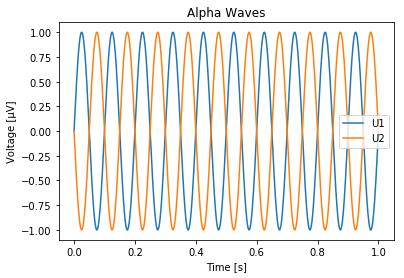

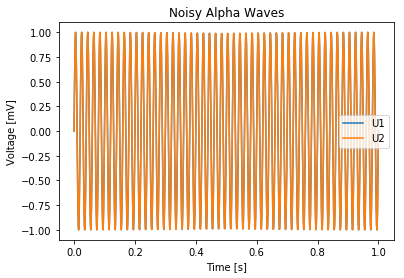

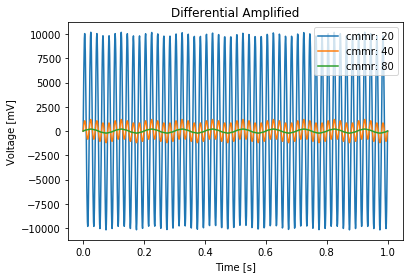

In [4]:
time = np.linspace(0,1,1000)
amplitude0 = np.sin(2*np.pi*10*time)
amplitude1 = -np.sin(2*np.pi*10*time)
plt.plot(time, amplitude0,label = "U1")
plt.plot(time, amplitude1,label = "U2")
plt.title("Alpha Waves")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [µV]")
plt.legend()
plt.show() 

amplitudeN = np.sin(2*np.pi*50*time)
amp0=amplitude0/1000+amplitudeN
amp1=amplitude1/1000+amplitudeN
plt.plot(time, amp0,label = "U1")
plt.plot(time, amp1,label = "U2")
plt.title("Noisy Alpha Waves")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]")
plt.legend()
plt.show() 


cmmr=[20,40,80]
G=100000
for i in range(len(cmmr)):
    Gcm=G/(10**(cmmr[i]/20))
    Ua=G*(amp0-amp1)+0.5*Gcm*(amp0+amp1)
    plt.plot(time, Ua,label="cmmr: {}".format(cmmr[i]))
plt.title("Differential Amplified")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]")
plt.legend() 





## Task 2: noise & signal models (4 points)
Simulate and plot noise & a simple alpha-oscillation model on a timescale of $5s$ with a sampling frequency of $1kHz$.

a) Generate a function *noise_w* that implements gaussian white noise with the variance $\sigma_n$ as an input parameter. White noise can be simply generated using np.random functions and the gaussian one would use the np.random.normal or np.random.randn.

b) Use the white noise function to produce pink noise (1/f) *noise_p* by frequency filtering it in the spectral domain. Therefor do a fourier transformation (np.fft.rfft) of the white noise, get the corresponding frequencies (np.fft.rfftfreq) and then multiply the fourier transfromed signal by $\frac{1}{f^{0.5}}$ (the factor $\frac{1}{f}$ is defined in the power spectrum which leads to $\sqrt{\frac{1}{f}}=\frac{1}{f^{0.5}}$ in the amplitude spectrum). As the DC part ($f=0$) would lead to a division by zero, you can simply divide the coresponding fft value by 1 instead.
Then transform the signal back to time domain (np.fft.irfft).

c) Do the same as for the pink noise to generate a simulated alpha oscillation *x_alpha* by tranformation of white noise to the frequency domain, spectral filtering and then transformation back to the time domain. For the shape in the frequency domain, use a peak function similar to that found in EEG.  A gaussian peak from 8 to 13 Hz with a standard deviation of $\frac{1}{10}$ of it's window (8-13Hz) width and the function *scipy.signal.gaussian(N,std)* as an approximation to the peak of an alpha oscillation in the frequency spectrum or similar is sufficient.

Plot all three noise & signal models into one plot first in the time domain and then in a secon plot in the frequency domain.

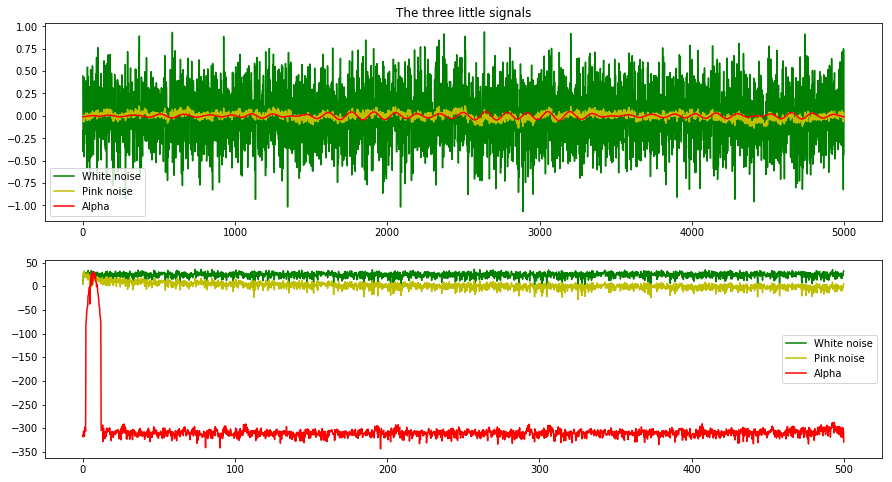

In [5]:
time = 5000
fs = 1000

def noise_w(sigma_n, time):
    return np.random.normal(loc = 0, scale = sigma_n, size = time)

def noise_p(noise_w,time, fs):
    signal = np.fft.rfft(noise_w)
    freq = np.fft.rfftfreq(5000, 1/fs)
    freq[freq==0] = 1
    filtered_fft = signal*(1/np.sqrt(freq))
    filtered_signal = np.fft.irfft(filtered_fft)
    return filtered_signal

def x_alpha(noise_w, time, fs, N = 50):
    
    signal = np.fft.rfft(noise_w)
    freq = np.fft.rfftfreq(time, 1/fs)
    freq
    gaus = scipy.signal.gaussian(N,N/10)
    width = (10,(len(freq)-len(gaus)-10) )
    gaus_pad = np.pad(gaus, width, mode = 'constant')
    filtered_fft = gaus_pad*signal
    filtered_signal = np.fft.irfft(filtered_fft)
    return filtered_signal
    

w_noise = noise_w(0.3,time)
p_noise = noise_p(w_noise,time,fs)
alpha_x = x_alpha(w_noise, time,fs)

freq  = np.fft.rfftfreq(time, d = 1/fs)
w_fourier = np.fft.rfft(w_noise)
p_fourier = np.fft.rfft(p_noise)
A_fourier = np.fft.rfft(alpha_x)

plt.figure(figsize = (15,8))
plt.subplot(211)
plt.title("The three little signals")
plt.plot(w_noise, "g", label = "White noise")
plt.plot(p_noise, "y", label = "Pink noise")
plt.plot(alpha_x, "r", label = "Alpha")
plt.legend()
    
plt.subplot(212)
plt.plot(freq, 20*np.log10( abs( w_fourier ) ), "g", label = "White noise" )
plt.plot(freq, 20*np.log10( abs( p_fourier ) ), "y", label = "Pink noise" )
plt.plot(freq, 20*np.log10( abs( A_fourier ) ), "r", label = "Alpha" )
plt.legend()

## Task 3 EEG simulation (3 points)

a) Generate a signal 

$v(t)=\alpha_x x(t)+\alpha_w n_w(t)+\alpha_p n_p(t)$, 

where $x(t)$ is the simulation an alpha osicllation *x_alpha*, $w_n$ is white noise and $p_n$ is pink noise. The $\alpha$s are the corresponding weights to account for individual signal powers. Plot the time course for a single channel of length $5s$ with a sampling frequency of 1kHz. Do a frequency transformation using the fourier transform and plot the power spectrum. Tune your weights $\alpha$ to get a roughly EEG-like spectrum.

b) Use the leadfield of one dipole of your choice (without amplifier input impedance) and simulate the scalp potential $v$ of an alpha oscillation in that source *s* by multiplying it with the leadfield $x(t)=L\cdot s(t)$. You can also load the scalp pattern produced by dipole 2081 in $p=[0, \sqrt[]\frac{2}{3}, \sqrt[]\frac{1}{3} ]^T$ saved in 'patternDip2081.npy' to avoid the calculations. Plot the time course for channels Cz and Oz into one plot. Also, plot the power spectrum for the two channels.

c) Repeat task a) but this time use the scalp potential $x(t)$ produced in b) to simulate an EEG. Add the noise independently to each channel allthough this is not fully realistic.

$v(t)=x(t)+\alpha_w n_w(t)+\alpha_p n_p(t)$

Again, plot the time course and the power spectrum for channels Cz and Oz.

d) Use the scalpmap function of the BBCI minitoolbox to plot the scalp pattern of the 10 Hz component in the fourier transform of the signal of task c) and compare it to the plain scalp pattern of that source. To extract the pattern, simply take the values at the peak (f==10Hz). This can be mutliplied with the source activity.

*Hint: You can use the exercise5_helper if you haven't succeeded with task 4!*

In [107]:
patternDip2081=np.load('patternDip2081.npy')
clab=np.load('clab.npy')

In [112]:
patternDip2081.shape

(72, 1)

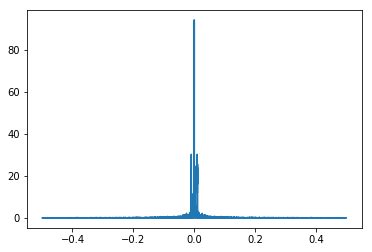

In [111]:
alpha_x=1.0
alpha_w=0.002
alpha_p=0.5

w=helper.noise_w(0.1,5000)
p=helper.noise_p(0.1,1000,5000)
x=helper.alpha(0.1,1000,5000)

v=alpha_x*x+alpha_w*w+alpha_p*p
fourier = np.fft.fft(v)
freq=np.fft.fftfreq(5000)

plt.plot(freq,np.abs(fourier)**2)
plt.show()


In [115]:
print(patternDip2081.shape)
print(clab.shape)

(72, 1)
(72,)


## Task 5: The MUSIC algorithm (6 points)
In EEG source reconstruction one of the most straight-forward approaches is to estimate the most probable source of a signal by finding the closest possible soulution to measured scalp potentials from a discrete set of dipoles. To this extent, the leadfield $L$ with dimensions NoChannels x NoDipoles x 3 is used for every dipole location to approximate the measured potential $v$ and then the closest mostly in a $L_2$ norm is expected to be the most probable source.

Luckily, the MUSIC algorithm does that for you and you have the function provided. The function returns the most probable source location index imax, it's potential vmax it produces along with the orientation/moment of the optimal dipole dip_mom and other parameters.

The true source ID is 2499.

There are EEG simulations of two different noise levels in the files "alphascalphighSNR.npy" and "alphascalplowSNR.npy". The true source without noise can be simulated by v_sim=L[:,iDip,:], where *iDip* is the true source ID 2499. You need to accord for the right orientation using the dotproduct with gridnorm[:,iDip].

** Tasks:**

a)  Determine the index of the dipole with minimum amplitude error for each noise level in the simualted potentials *v_sim* for each of the noise levels ( v_sim = no noise, v_sim_noiseL = low noise, v_sim_noiseH = high noise). Use the music algorithm and also calculate the localization error as the Euclidean distance between the source found (dip_loc) and the real position of the source (the right entry of gridpos).

b) Investigate the simulated scalp potentials *v_sim* with the *bci.scalpmap* function of the bci_minitoolbox and try to explain the different results in source localization.

c) Load the scalp pattern *alphascalp.npy* which originates in real EEG data taken from a motor imagery experiment. The PSD values where tansformed to amplitudes (square root) and normalized. Find the best matching source location using the music function, but this time search in the leafield *leadfield_relab.npy* that is relabeled to the different set of electrodes in the real data. Also, plot the scalmaps of the *alphascalp.npy* and compare it to the one of the dipole found. What's the difference? What could be the reason for this?

In [7]:
iDip=2499

L=np.load('leadfield3dim.npy')
gridpos=np.load('gridpos.npy')
gridnorms=np.load('gridnorms.npy')
v_sim_noiseL=np.load('alphascalphighSNR.npy')
v_sim_noiseH=np.load('alphascalplowSNR.npy')

mnt = np.load("mnt.npy")

In [8]:
L_relab=np.load('leadfield3dimrelab.npy')
alphascalp=np.load('alphascalp.npy')
mnt_alpha = np.load("mnt_alphascalp.npy")

In [9]:
v_sim = np.expand_dims(L[:,iDip,:].dot(gridnorms[:,iDip]).T , 1)

s, vmax, imax, dip_mom, dip_loc = music(v_sim, L, gridpos)

In [14]:
# v_simNoiseL

sL, vmaxL, imaxL, dip_momL, dip_locL = music(v_sim_noiseL, L, gridpos)
Error_noiseL = np.linalg.norm(dip_locL - gridpos[iDip,:])

In [15]:
# v_simNoiseH

sH, vmaxH, imaxH, dip_momH, dip_locH = music(v_sim_noiseH, L, gridpos)
Error_noiseH = np.linalg.norm(dip_locH - gridpos[iDip,:])

In [16]:
# a

print("MUSIC index for no noise simulated source signal is:", imax)
print("MUSIC index for High Noise simulated source signal is:", imaxH)
print("MUSIC index for Low Noise simulated source signal is:", imaxL)
print("\n")
print("Error for the low noise as Eucludian distance is:", Error_noiseL)
print("Error for the high noise as Eucludian distance is:", Error_noiseH)

MUSIC index for no noise simulated source signal is: 2499
MUSIC index for High Noise simulated source signal is: 1866
MUSIC index for Low Noise simulated source signal is: 2803


Error for the low noise as Eucludian distance is: 0.004763962829216599
Error for the high noise as Eucludian distance is: 0.013863580791048706


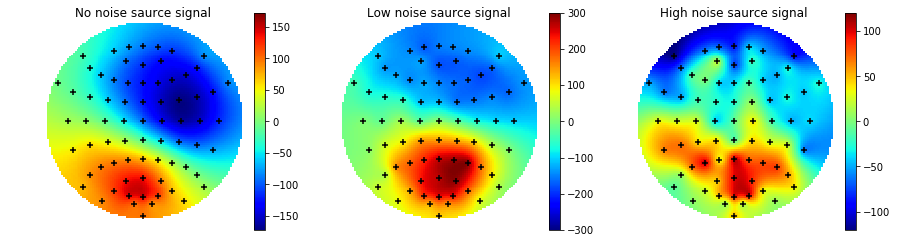

In [17]:
plt.figure(figsize= (15,8))

plt.subplot(131)
plt.title("No noise saurce signal")
bci.scalpmap(mnt,v_sim, clim="sym")

plt.subplot(132)
plt.title("Low noise saurce signal")
bci.scalpmap(mnt,v_sim_noiseL, clim="sym" )

plt.subplot(133)
plt.title("High noise saurce signal")
bci.scalpmap(mnt,v_sim_noiseH, clim="sym")

In [18]:
alphascalp = np.expand_dims(alphascalp,1)
sA, vmaxA, imaxA, dip_momA, dip_locA = music(alphascalp, L_relab, gridpos)

Text(0.5, 1.0, 'MUSIC alphascalp')

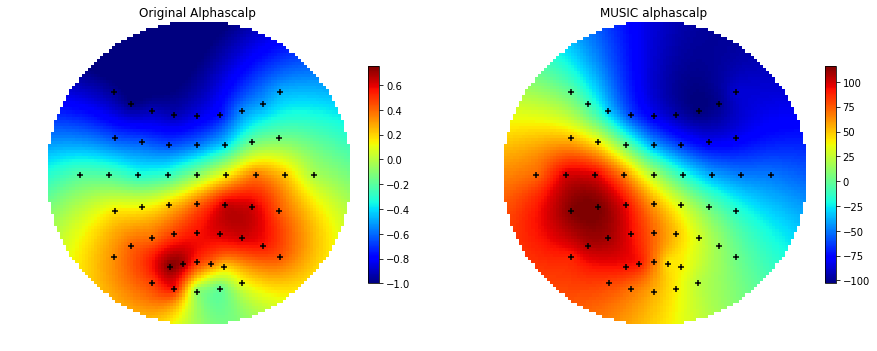

In [20]:
v_simA = L_relab[: , imaxA, :].dot(gridnorms[:, imaxA])

plt.figure(figsize=(15,8))

plt.subplot(121)
bci.scalpmap(mnt_alpha, alphascalp)
plt.title("Original Alphascalp")

plt.subplot(122)
bci.scalpmap(mnt_alpha, v_simA)
plt.title("MUSIC alphascalp")